# PTCGP — Part 2: Core → MARS (preview)

Pipeline **Part 2**: carica gli output della parte 1 (matrici filtrate e score filtrata),
esegue **MARS** (AUTO\_K-CV → Posteriori → MAS/LB → BT → Composito), mostra ranking e copertura,
e salva i risultati in `outputs/RankingData/MARS/`.


In [1]:
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s | %(name)s | %(message)s', force=True)
log = logging.getLogger('ptcgp')

In [2]:
from pathlib import Path
import pandas as pd, numpy as np
import sys

BASE_DIR = Path.cwd()
sys.path.append(str(BASE_DIR))  # ok per progetto locale

from utils.io import init_paths, write_csv_versioned, _dest  # _dest servirà per i percorsi
PATHS = init_paths(BASE_DIR)

from mars.config import MARSConfig     # ← più robusto
from mars.pipeline import run_mars


In [3]:
import yaml

CFG_PATH = BASE_DIR / "config" / "config.yaml"   # usa BASE_DIR per coerenza
CFG_PATH.parent.mkdir(parents=True, exist_ok=True)

if not CFG_PATH.exists():
    log.warning("config.yaml mancante: creo placeholder minimale (mars default).")
    CFG_PATH.write_text("logging:\n  level: INFO\nmars: {}\n", encoding="utf-8")

CFG = yaml.safe_load(CFG_PATH.read_text(encoding="utf-8")) or {}

# livello log dal config (fallback INFO)
level_str = str(CFG.get("logging", {}).get("level", "INFO")).upper()
log.setLevel(getattr(logging, level_str, logging.INFO))

# Attenzione: le chiavi in YAML devono combaciare con i nomi di MARSConfig (UPPERCASE)
mars_cfg = MARSConfig(**CFG.get("mars", {}))
mars_cfg


MARSConfig(MU=0.5, Z_PENALTY=1.2, ALPHA_COMPOSITE=0.72, AUTO_GAMMA=False, GAMMA_META_BLEND=0.3, GAMMA_MIN=0.1, GAMMA_MAX=0.6, GAMMA_BASE=0.1, GAMMA_SLOPE=1.5, META_GAP_POLICY='encounter', HALF_TIES=False, HALF_TIES_WEIGHT=0.5, AUTO_K=True, K_MIN=0.1, K_CONST_BOUNDS=[0.05, 50.0], INSTANT_APPLY_K=True, K_BASE=4.0, K_SCALE=2.0, K_BASE_BOUNDS=[1.0, 12.0], K_SCALE_BOUNDS=[0.5, 3.0], RHO_TEST=0.3333333333, BOOT_N=50, SEED=42, REL_TOL_LL=0.001, EXPAND_LO_STEPS=2, K_GRID_MULTS=[0.25, 0.5, 1.0, 2.0, 4.0], BOOT_LOCAL_MULTS=[0.7071067812, 1.0, 1.4142135624], MIN_TEST_IF_N_GE_4=2, MIN_TRAIN_IF_N_GT_1=1, N_MIN_BT_TARGET=5, BT_SOFT_POWER=None, BT_NEAR_BAND=0.1, BT_USE_HARMONIC_N=True, LAMBDA_RIDGE=1.5, MAX_BT_ITER=500, BT_TOL=1e-06, EPS=1e-12)

In [4]:
from pathlib import Path
import pandas as pd

wr_path = BASE_DIR / "outputs" / "Matrices" / "winrate" / "filtered_wr_latest.csv"
nd_path = BASE_DIR / "outputs" / "Matrices" / "volumes" / "n_dir_latest.csv"
sc_path = BASE_DIR / "outputs" / "MatchupData" / "flat" / "score_latest.csv"
tm_path = BASE_DIR / "outputs" / "Decklists" / "top_meta" / "top_meta_decklist_latest.csv"

if not wr_path.exists() or not nd_path.exists() or not sc_path.exists():
    raise FileNotFoundError(
        "Mancano uno o più input della Parte 1: controlla filtered_wr_latest, n_dir_latest, score_latest."
    )

wr = pd.read_csv(wr_path, index_col=0)
nd = pd.read_csv(nd_path, index_col=0)
# assi canonici in stringa
wr.index = wr.index.astype(str); wr.columns = wr.columns.astype(str)
nd.index = nd.index.astype(str); nd.columns = nd.columns.astype(str)

score = pd.read_csv(sc_path)
need_cols = {"Deck A", "Deck B", "W", "L", "T", "N", "WR_dir"}
missing = need_cols.difference(score.columns)
if missing:
    raise ValueError(f"score_latest.csv manca colonne: {sorted(missing)}")

top_meta = pd.read_csv(tm_path) if tm_path.exists() else None

log.info("Input caricati | decks=%d | score_rows=%d", len(wr.index), len(score))


INFO | ptcgp | Input caricati | decks=25 | score_rows=574


In [5]:
# shape & axis alignment
assert wr.shape == nd.shape, "Shape mismatch tra filtered_wr e n_dir"
assert wr.index.equals(nd.index) and wr.columns.equals(nd.columns), "Assi non allineati"

# diagonal NaN
assert np.all(np.isnan(np.diag(wr.values))), "Diag filtered_wr deve essere NaN"
assert np.all(np.isnan(np.diag(nd.values))), "Diag n_dir deve essere NaN"

# simmetria n_dir (regola max N_dir già imposta a monte → N simmetrica)
nd_np = nd.to_numpy(dtype=float)
assert np.allclose(nd_np, nd_np.T, equal_nan=True), "n_dir non simmetrica"

# mask off-diagonale
T = len(wr.index)
off = ~np.eye(T, dtype=bool)

# range check
wr_off = wr.to_numpy(dtype=float)[off]
nd_off = nd.to_numpy(dtype=float)[off]
wr_off = wr_off[~np.isnan(wr_off)]

assert np.all((wr_off >= -1e-6) & (wr_off <= 100 + 1e-6)), "WR fuori range (0..100)"
assert np.all(nd_off[~np.isnan(nd_off)] >= -1e-9), "n_dir ha valori negativi off-diag"

# simmetria WR: WR(A,B) + WR(B,A) ≈ 100 (entro 0.2 pp)
wr_np = wr.to_numpy(dtype=float)
sum_sym = wr_np + wr_np.T
sum_sym_off = sum_sym[off]
sum_sym_off = sum_sym_off[~np.isnan(sum_sym_off)]
assert np.allclose(sum_sym_off, 100.0, rtol=0.0, atol=0.2), "WR(A,B)+WR(B,A) non ≈ 100"

log.info("Validator base: OK")


INFO | ptcgp | Validator base: OK


In [6]:
# === Run MARS =================================================================
ranking, diag, coverage_df, missing_pairs_long = run_mars(
    filtered_wr=wr, n_dir=nd, score_flat=score, top_meta_df=top_meta, cfg=mars_cfg
)

# === Logs INFO compatti =======================================================
ak   = diag.get("AUTO_K", {})
meta = diag.get("META", {})
bt   = diag.get("BT", {})
comp = diag.get("COMP", {})

# AUTO-K
log.info(
    "[AUTO_K-CV] grid=%s | K*=%0.3f → used=%0.3f (%s) | ΔLL/100=%0.4f | r_p50=%0.3f | r_small_med=%0.3f",
    ak.get("grid", ak.get("K_grid")),
    float(ak.get("K_star", np.nan)),
    float(ak.get("K_used", np.nan)),
    ak.get("used_reason", ak.get("reason", "")),
    float(ak.get("dLL_per100", ak.get("delta_ll_100", np.nan))),
    float(ak.get("r_p50", np.nan)),
    float(ak.get("r_small_med", np.nan)),
)

# META
log.info(
    "[META] policy=%s | AUTO=%s | gamma=%0.3f | TV=%0.3f | corr=%0.3f",
    meta.get("policy"),
    str(meta.get("AUTO_GAMMA")),
    float(meta.get("gamma", np.nan)),
    float(meta.get("tv", np.nan)),
    float(meta.get("corr", np.nan)),
)

# BT
near_pct = bt.get("near_thresh_pct", bt.get("near_pct", 0.0))
s_med    = bt.get("s_bar_median", bt.get("s_med", np.nan))
soft_val = bt.get("BT_SOFT_POWER", bt.get("soft_power", np.nan))
pow_mode = bt.get("BT_SOFT_POWER_mode", bt.get("soft_power_mode", ("auto-cont" if mars_cfg.BT_SOFT_POWER is None else "set")))

log.info(
    "[BT] kept=%d drop=%d | near%%=%0.1f | s_med=%0.3f | min/med_opp=%d/%0.1f | γ_soft=%0.2f (%s)",
    int(bt.get("kept", 0)),
    int(bt.get("dropped", 0)),
    float(near_pct),
    float(s_med),
    int(bt.get("min_opp", 0)),
    float(bt.get("med_opp", np.nan)),
    float(soft_val),
    pow_mode,
)

# COMP
log.info("[COMP] α=%0.2f", float(comp.get("alpha", mars_cfg.ALPHA_COMPOSITE)))

# OUT
log.info("[OUT] decks=%d | ranking/coverage/missing pronti", len(wr.index))

# === Anteprima ================================================================
ranking.head(10)


INFO | ptcgp | [AUTO_K-CV] grid=[1.648863, 3.297726, 6.595453, 13.190906, 26.381812, 50.0] | K*=3.298 → used=4.664 (boot-clipped) | ΔLL/100=-0.0311 | r_p50=0.368 | r_small_med=0.700
INFO | ptcgp | [META] policy=encounter | AUTO=False | gamma=0.300 | TV=0.385 | corr=nan
INFO | ptcgp | [BT] kept=179 drop=108 | near%=17.9 | s_med=0.785 | min/med_opp=4/15.0 | γ_soft=1.66 (auto-cont)
INFO | ptcgp | [COMP] α=0.72
INFO | ptcgp | [OUT] decks=25 | ranking/coverage/missing pronti


,Deck,Score_%,MAS_%,LB_%,BT_%,SE_%,N_eff,Opp_used,Opp_total,Coverage_%
Rank,,,,,,,,,,
1,Suicune ex Greninja,97.472588,54.768007,53.569909,78.412942,0.998415,3381.0,24,24,100.000000
2,Silvally Rampardos,85.352467,52.990404,50.191216,67.115528,2.332657,433.0,24,24,100.000000
3,Giratina ex Darkrai ex,84.293862,51.292699,49.668330,72.483273,1.353641,2059.0,24,24,100.000000
4,Guzzlord ex,83.853138,51.365914,49.515100,73.683604,1.542345,1487.0,24,24,100.000000
5,Flareon ex Eevee ex,80.427827,52.504698,50.151766,53.160445,1.960777,822.0,24,24,100.000000
6,Dragonite ex Sylveon ex,77.969020,51.509244,48.009005,82.575334,2.916866,190.0,23,24,95.833333
7,Suicune ex Giratina ex,73.633823,51.118094,48.327573,66.804217,2.325435,510.0,23,24,95.833333
8,Silvally Oricorio,72.747062,51.457070,48.712071,58.348549,2.287500,524.0,23,24,95.833333
9,Raikou ex Tapu Koko ex,72.345772,50.327059,46.999754,86.101793,2.772754,253.0,24,24,100.000000


In [7]:
from utils.display import show_ranking

# Mostra Top-15 (default)
# show_ranking(ranking)

# Mostra Top-N custom
show_ranking(ranking, top_n=25)

# Se N > len(ranking) → mostra tutto
# show_ranking(ranking, top_n=999)

# Con subset di colonne e formati custom
# show_ranking(
#     ranking,
#     top_n=10,
#     cols=["Deck", "Score_%", "LB_%", "BT_%", "Coverage_%"],
#     fmt={"Coverage_%": "{:.2f}"},
#     title="MARS — Top 10 (compact view)"
# )


,Deck,Score_%,LB_%,MAS_%,BT_%,SE_%,N_eff,Opp_used,Opp_total,Coverage_%
Rank,,,,,,,,,,
1,Suicune ex Greninja,97.47,53.57,54.77,78.41,1.00,3381,24,24,100.0
2,Silvally Rampardos,85.35,50.19,52.99,67.12,2.33,433,24,24,100.0
3,Giratina ex Darkrai ex,84.29,49.67,51.29,72.48,1.35,2059,24,24,100.0
4,Guzzlord ex,83.85,49.52,51.37,73.68,1.54,1487,24,24,100.0
5,Flareon ex Eevee ex,80.43,50.15,52.50,53.16,1.96,822,24,24,100.0
6,Dragonite ex Sylveon ex,77.97,48.01,51.51,82.58,2.92,190,23,24,95.8
7,Suicune ex Giratina ex,73.63,48.33,51.12,66.80,2.33,510,23,24,95.8
8,Silvally Oricorio,72.75,48.71,51.46,58.35,2.29,524,23,24,95.8
9,Raikou ex Tapu Koko ex,72.35,47.00,50.33,86.10,2.77,253,24,24,100.0


In [8]:
# === Salvataggi MARS (solo ranking) ==========================================
from utils.io import write_csv_versioned

mars_out = BASE_DIR / "outputs" / "RankingData" / "MARS"
mars_out.mkdir(parents=True, exist_ok=True)

# SOLO ranking, con copia versionata quando cambia
write_csv_versioned(ranking, mars_out, "mars_ranking", changed=True, index=False)
# write_csv_versioned(coverage_df, mars_out, 'mars_coverage', changed=True, index=False)
# write_csv_versioned(missing_pairs_long, mars_out, 'mars_missing_pairs', changed=True, index=False)

# NIENTE coverage, NIENTE missing, NIENTE logs JSON
log.info("Salvataggio completato: SOLO mars_ranking in %s", mars_out)


INFO | utils.io | CSV aggiornato: c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\RankingData\MARS\mars_ranking_latest.csv
INFO | utils.io | CSV versionato (changed=True): c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\RankingData\MARS\mars_ranking_20250914_231837.csv
INFO | ptcgp | Salvataggio completato: SOLO mars_ranking in c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\RankingData\MARS


INFO | utils.io | Plot salvato (timestamp + latest): c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\Matrices\heatmap\wr_heatmap_T10_20250914_231837.png | latest: c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\Matrices\heatmap\wr_heatmap_latest.png


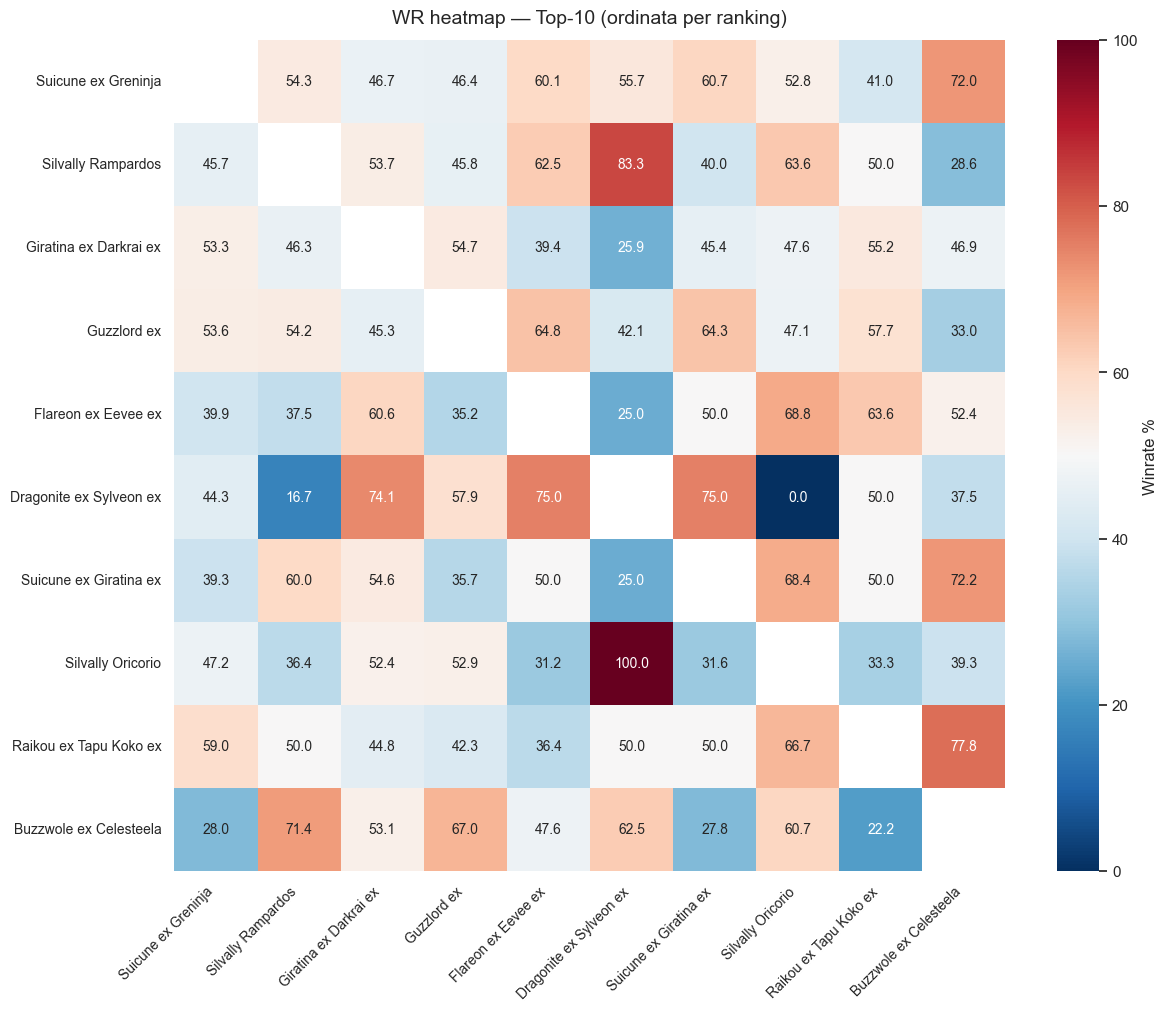

In [9]:
# === Heatmap WR — opzioni pronte all'uso =====================================
from utils.display import show_wr_heatmap
from utils.io import _dest

# Directory di salvataggio per heatmap (route ufficiale)
heatmap_dir = _dest(PATHS, "heatmap_topN")  # 'paths' creato a inizio notebook con init_paths(BASE)

# 0) Default: Top-10, annotazioni con 1 decimale (fmt='.1f'), diagonale bianca
fig, ax, wr_sub = show_wr_heatmap(
    ranking,
    wr=wr,          # filtered_wr_latest già caricato come 'wr'
    top_n=10,       # clamp robusto tra 2 e len(ranking)
    annot=True,     # True per mostrare i valori
    fmt=".1f",
    save = True
)



# ── Varianti (scommenta UNA per volta) ───────────────────────────────────────

# 1) Top-15 con annotazioni intere e maschera triangolo superiore (meno clutter)
# show_wr_heatmap(ranking, wr=wr, top_n=15, annot=True, fmt=".0f", mask_mirror=True)

# 2) Tutto il ranking; figura più ampia
# show_wr_heatmap(ranking, wr=wr, top_n=len(ranking), figsize=(14, 12), annot=False)

# 3) Colormap alternativa (vlag), centrata su 50%
# show_wr_heatmap(ranking, wr=wr, top_n=20, cmap="vlag", annot=True, fmt=".1f")

# 4) SALVA — duale: wr_heatmap_latest + wr_heatmap_T{T}_<timestamp>.png
# show_wr_heatmap(ranking, wr=wr, top_n=15, annot=True, save=True, save_dir=heatmap_dir)

# 5) SALVA — tutto il ranking, con annotazioni intere
# show_wr_heatmap(ranking, wr=wr, top_n=len(ranking), annot=True, fmt=".0f", save=True, save_dir=heatmap_dir)


In [10]:
# === MARS — Matchup Report (Excel, per-deck) — ordine ranking, riga Mirror, styling ===
import logging
import pandas as pd
from utils.io import _dest, write_excel_versioned_styled
from mars.meta import blend_meta
from mars.auto_k_cv import auto_k_cv
from mars.report import make_pairs_by_deck_tables, prepare_workbook, build_summary_sheet, _reorder_excel_sheets_robust

log = logging.getLogger("ptcgp")

# 1) Contratti latest
p_filtered_wr = _dest(PATHS, "filtered_wr") / "filtered_wr_latest.csv"
p_n_dir       = _dest(PATHS, "n_dir")        / "n_dir_latest.csv"
p_score_flat  = _dest(PATHS, "matchup_score_table") / "score_latest.csv"
p_ranking     = _dest(PATHS, "mars_ranking")        / "mars_ranking_latest.csv"
p_top_meta    = _dest(PATHS, "top_meta_decklist")   / "top_meta_decklist_latest.csv"

filtered_wr = pd.read_csv(p_filtered_wr, index_col=0)
n_dir       = pd.read_csv(p_n_dir, index_col=0)
score_flat  = pd.read_csv(p_score_flat)
ranking_df  = pd.read_csv(p_ranking)
top_meta_df = pd.read_csv(p_top_meta) if p_top_meta.exists() else None

axis = list(filtered_wr.index)

# Ordine ranking (top→bottom) + fallback per eventuali deck extra nelle matrici
rank_topdown = (
    ranking_df.sort_values("Score_%", ascending=False, kind="mergesort")["Deck"]
    .astype(str).tolist()
)
global_order = [d for d in rank_topdown if d in axis] + [d for d in axis if d not in rank_topdown]

missing_in_rank = [d for d in axis if d not in rank_topdown]
if missing_in_rank:
    log.warning("Report: %d deck non presenti nel ranking, aggiunti in coda all'ordine: %s",
                len(missing_in_rank), ", ".join(missing_in_rank))

log.info("Report: loaded contracts (T=%d).", len(axis))

# 2) p(B) e K (stessa logica della pipeline)
p_weights, meta_info = blend_meta(axis, n_dir, top_meta_df, mars_cfg)

W = (score_flat.pivot_table(index="Deck A", columns="Deck B", values="W", aggfunc="sum")
               .reindex(index=axis, columns=axis))
L = (score_flat.pivot_table(index="Deck A", columns="Deck B", values="L", aggfunc="sum")
               .reindex(index=axis, columns=axis))
N = (W.fillna(0.0) + L.fillna(0.0)).reindex(index=axis, columns=axis)

K_used = float(auto_k_cv(W, L, N, mars_cfg)["K_used"])
log.info("Report: K_used=%.3f | gamma=%s", K_used, meta_info.get("gamma"))

# 3) Tabelle per-deck (ordine fisso = ranking, con riga Mirror)
sheets_by_deck, legend_df, meta = make_pairs_by_deck_tables(
    filtered_wr=filtered_wr,
    n_dir=N,
    p_blend=p_weights,
    K_used=K_used,
    score_flat=score_flat,
    include_posterior_se=True,
    include_binom_se=True,
    gamma=meta_info.get("gamma"),
    include_counts=True,
    sort_by=None,                  # disattivato: usiamo global_order fisso
    global_order=global_order,     # ordine righe coerente col ranking
    include_self_row=True,         # riga "Mirror" presente
    mirror_label="Mirror",
)

# 4) Foglio 01_Summary + workbook
summary_df = build_summary_sheet(ranking_df)
workbook = prepare_workbook(sheets_by_deck, legend_df, summary_df=summary_df)

# 5) Salvataggio con styling (semafori gap, Top-K, Mirror grigio, legenda colori)
out_dir = _dest(PATHS, "report")
ts_path, latest_path = write_excel_versioned_styled(
    workbook=workbook,
    base_dir=out_dir,
    prefix=f"pairs_by_deck_T{meta['T']}",
    tag="MARS",
    include_latest=True,
    also_versioned=True,
    top_k_contrib=5,
)

# 6) **NUOVO** — Riordino robusto dei fogli secondo il ranking (gestisce sanificazione/31 char/duplicati)
desired_decks = global_order  # top→bottom + eventuali extra in coda
_reorder_excel_sheets_robust(ts_path,     desired_decks)
_reorder_excel_sheets_robust(latest_path, desired_decks)

log.info("Report (styled + reordered) scritto: versioned=%s | latest=%s", ts_path, latest_path)


INFO | ptcgp | Report: loaded contracts (T=25).
INFO | ptcgp | Report: K_used=4.664 | gamma=0.3
INFO | utils.io | Excel versionato (styled): c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\RankingData\MARS\Report\pairs_by_deck_T25_MARS_20250914_231843.xlsx
INFO | utils.io | Excel latest (styled): c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\RankingData\MARS\Report\pairs_by_deck_T25_latest.xlsx
INFO | ptcgp | Report (styled + reordered) scritto: versioned=c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\RankingData\MARS\Report\pairs_by_deck_T25_MARS_20250914_231843.xlsx | latest=c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\RankingData\MARS\Report\pairs_by_deck_T25_latest.xlsx
